## Part 1 - Spark RDDs

### P1.1 Loading data into an RDD (not assessed)

Task: You need to load the data into an RDD consisting of string elements, each element corresponding to the text of a Wikipedia page. Precisely, each RDD element should be a string equal to the text enclosed within `<page>` and `</page>` XML tags in the input dataset with carriage-return characters (`\n`) removed.

Output 1: Show the first element of the RDD. 

Output 2: Show the number of elements of this RDD.

**Your action:** use the code snippet provided in `loadWikipediaData.ipynb` to perform these steps and get an initial RDD (`rdd2`). All the remaining questions can be answered based on this initial RDD. Remember to change your cluster name and IP port to reflect the path to the dataset on Hadoop.

```
path = "hdfs://cluster-assignment1-m:8020/enwiki-latest-pages-articles1.xml"
```


In [2]:
# Wikipedia dump
# we use the enwiki-latest-pages-articles1.xml-p1p41242.bz2 dump
!wget https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
# decompress the file
!bzip2 -d enwiki-latest-pages-articles1.xml-p1p41242.bz2
# rename the uncompressed file to an XML format
!mv enwiki-latest-pages-articles1.xml-p1p41242 enwiki-latest-pages-articles1.xml
# move to Hadoop Namenode
!hadoop fs -put enwiki-latest-pages-articles1.xml /

--2024-02-22 15:27:58--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.71, 2620:0:861:3:208:80:154:71
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276785341 (264M) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’

enwiki-latest-pages 100%[===================>] 263.96M  4.36MB/s    in 62s     

2024-02-22 15:29:01 (4.26 MB/s) - ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’ saved [276785341/276785341]

put: `/enwiki-latest-pages-articles1.xml': File exists


In [3]:
# adjust to reflect the cluster name and Hadoop masternode (IP port) of your cluster
path = "hdfs://cluster-assignment1-m:8020/enwiki-latest-pages-articles1.xml"


In [4]:
# initial Dataframe
# pages are separated by <page> and </page>
df1 = spark.read.text(path, lineSep="</page>")
df1.limit(10).toPandas()

,value
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml..."
1,\n <page>\n <title>Anarchism</title>\n ...
2,\n <page>\n <title>AfghanistanHistory</tit...
3,\n <page>\n <title>AfghanistanGeography</t...
4,\n <page>\n <title>AfghanistanPeople</titl...
5,\n <page>\n <title>AfghanistanCommunicatio...
6,\n <page>\n <title>AfghanistanTransportati...
7,\n <page>\n <title>AfghanistanMilitary</ti...
8,\n <page>\n <title>AfghanistanTransnationa...
9,\n <page>\n <title>AssistiveTechnology</ti...


In [5]:
# accessing RDD element attached to the Dataframe
rdd1 = df1.rdd

In [6]:
# numPartitions depend on the cluster machine being used
# for instance, N2 4 vCPUs will give you 8 partitions
rdd1.getNumPartitions()

8

In [7]:
# first element
rdd1.take(1)

[Row(value='<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">\n  <siteinfo>\n    <sitename>Wikipedia</sitename>\n    <dbname>enwiki</dbname>\n    <base>https://en.wikipedia.org/wiki/Main_Page</base>\n    <generator>MediaWiki 1.42.0-wmf.18</generator>\n    <case>first-letter</case>\n    <namespaces>\n      <namespace key="-2" case="first-letter">Media</namespace>\n      <namespace key="-1" case="first-letter">Special</namespace>\n      <namespace key="0" case="first-letter" />\n      <namespace key="1" case="first-letter">Talk</namespace>\n      <namespace key="2" case="first-letter">User</namespace>\n      <namespace key="3" case="first-letter">User talk</namespace>\n      <namespace key="4" case="first-letter">Wikipedia</namespace>\n      <namespace key="5" case="first-letter">Wikipedi

In [8]:
# RDD2: all rows containing <page>
rdd2 = rdd1.filter(lambda row: "<page>" in row[0])

In [9]:
# split RDD2 based on <page> and with no carriage returns
rdd2 = rdd2.map(lambda row: row[0].split("<page>")[1].replace("\n", ""))

In [10]:
# first element of RDD2
rdd2.take(1)

['    <title>AccessibleComputing</title>    <ns>0</ns>    <id>10</id>    <redirect title="Computer accessibility" />    <revision>      <id>1002250816</id>      <parentid>854851586</parentid>      <timestamp>2021-01-23T15:15:01Z</timestamp>      <contributor>        <username>Elli</username>        <id>20842734</id>      </contributor>      <minor />      <comment>shel</comment>      <model>wikitext</model>      <format>text/x-wiki</format>      <text bytes="111" xml:space="preserve">#REDIRECT [[Computer accessibility]]{{rcat shell|{{R from move}}{{R from CamelCase}}{{R unprintworthy}}}}</text>      <sha1>kmysdltgexdwkv2xsml3j44jb56dxvn</sha1>    </revision>  ']

In [11]:
# number of elements in RDD2
rdd2.count()

27376

### Imports

In [12]:
import re
from datetime import datetime
from math import log2
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, LongType, TimestampType, StructType
from pyspark.sql.functions import length, split, col, size, count, year, month, explode


### P1.2 Number of categories per page

Task: Some Wikipedia pages contain information about categories to which they belong. For those Wikipedia pages, there can be one or more categories indicated in the Wikipedia dump file. Create a **key-value pair RDD** with keys corresponding to page IDs and values corresponding to the number of categories of the corresponding page (both Integer type).

Output: Show the key-value pairs of this pair RDD for the top 10 elements in decreasing order of values. 

Example: ```[('19856', 233), ('6198', 230),...```

In [13]:
def count_category_in_string(s):
    return s.count('Category:')

def split_rdd_and_count_categories(rdd):
    ids_and_categories = rdd.map(lambda x: x.split("<id>", 1))\
                            .filter(lambda x: len(x) > 1)\
                            .map(lambda x: x[1])\
                            .map(lambda x: x.split('</id>', 1))\
                            .map(lambda x: (x[0], count_category_in_string(x[1])))
    
    output = ids_and_categories.takeOrdered(10, lambda x: -x[1])
    return output

output = split_rdd_and_count_categories(rdd2)
print(output)

[('19856', 233), ('6198', 230), ('32753', 221), ('22107', 218), ('16775', 215), ('6201', 214), ('31898', 214), ('32124', 208), ('31940', 198), ('7851', 181)]


### P1.3 Top contributors

Task: In this exercise, we analyse the amount of contributions made by contributors in terms of the number of page revisions. Create a **key-value pair RDD** with keys corresponding to page IDs and the value corresponding to contributor IDs.

Create another **key-value pair RDD** with keys corresponding to contributor IDs and values corresponding to contributor names. Use these two pair RDDs to compute a third **key-value pair RDD** with keys corresponding to contributor IDs and values corresponding to a tuple with the first element corresponding to the number of pages revised by the contributor and the second element corresponding to the contributor's name. 

**Note**: filter out pages for which the username and ID of the contributor are not specified.

Output: Show the top 10 elements of this third RDD in decreasing order of the number of pages revised by the contributor.

Example: ```[(9784415, (1140, 'Tom.Reding')), (7903804, (1137, 'Citation bot')),...```

In [14]:

sc = SparkContext.getOrCreate()

############# Function to extract contributor sections
def extract_contributor(element):
    pattern = r"<contributor>(.*?)</contributor>"
    return re.findall(pattern, element)

############# Function to extract username and ID from the contributor section
def extract_username_id(contributor_section):
    username_match = re.search(r'<username>(.*?)</username>', contributor_section)
    id_match = re.search(r'<id>(\d+)</id>', contributor_section)
    if username_match and id_match:
        return (id_match.group(1), username_match.group(1))
    else:
        return None

############# Function to extract contributors info and create a distinct RDD
def extract_contributors_info(rdd):
    return rdd.filter(lambda x: '<username>' in x)\
              .flatMap(extract_contributor)\
              .map(extract_username_id)\
              .filter(lambda x: x is not None)\
              .distinct()

contributors_info_rdd = extract_contributors_info(rdd2)

############# Function to count contributions per contributor ID
def count_contributions(rdd):
    return rdd.filter(lambda x: '<username>' in x)\
              .flatMap(lambda x: re.findall(r'<id>(\d+)</id>', x))\
              .map(lambda x: (x, 1))\
              .reduceByKey(lambda x, y: x + y)

contributions_count_rdd = count_contributions(rdd2)

############# Function to combine contributions count with contributors info and sort
def combine_and_sort(rdd_contributions, rdd_contributors_info):

    return rdd_contributions.join(rdd_contributors_info)\
                            .map(lambda x: (x[0], (x[1][0], x[1][1])))\
                            .sortBy(lambda x: x[1][0], ascending=False)


final_rdd = combine_and_sort(contributions_count_rdd, contributors_info_rdd)

############# Print the top 10 contributors
top_contributors = final_rdd.take(10)
for contributor in top_contributors:
    print(contributor)


('7903804', (1266, 'Citation bot'))
('9784415', (1204, 'Tom.Reding'))
('194203', (432, 'Graham87'))
('20836525', (395, '1234qwer1234qwer4'))
('212624', (362, 'MZMcBride'))
('27015025', (355, 'InternetArchiveBot'))
('27823944', (275, 'GreenC bot'))
('44120587', (266, 'HeyElliott'))
('8066546', (232, 'Xqbot'))
('35936988', (203, 'JJMC89 bot III'))


### P1.4 Effective number of categories per contributor

Task: In this exercise, we analyse categories of Wikipedia pages revised by contributors. Create a **key-value pair RDD** with keys corresponding to contributor IDs and values being tuples with the first element corresponding to a page category and the second element corresponding to the number of revisions the contributor made to the category.

Using this pair RDD, create a new **key-value pair RDD** with keys corresponding to contributor IDs and values corresponding to a list with (1) the first element being the total number of revisions made by the contributor, (2) the second element being the number of distinct categories for which the contributor made at least one revision, and (3) the third element being the entropy of the distribution of the number of revisions over categories.

Output 1: Show the top 10 elements of sorted elements with respect to the total number of revisions per contributor. 

Output 2: Plot the entropy (y-axis) versus the total number of revisions per contributor (x-axis) (use log-scale for x-axis).

Example (output 1): ```[(7903804, [8676, 7420, 12.710079965830602]), (35936988, [3914, 3088, 11.39364202994587]),...```

Example (output 2): not given

**Note**: For any discrete distribution $p$ over a countable set of values $\{x_i\}$ such that $p_i$ is the probability of $x_i$, the entropy $H(p)$ is defined as $H(p) = -\sum_i p_i\log(p_i)$. (Use base 2 logarithm). In our application context, we may think of entropy as the number of information bits to encode the effective number of categories per contributor. If the contributor makes revisions only to one category, then entropy is equal to 0. The maximum entropy is achieved when the contributor evenly splits effort across categories.


Top 10 Contributors: [('7903804', (9799, 7909, 12.628928357159282)), ('35936988', (3674, 3093, 11.432486463426587)), ('27823944', (2988, 2743, 11.337735672701971)), ('27015025', (2774, 2623, 11.302823737989605)), ('7611264', (1546, 1469, 10.484183639517033)), ('44120587', (1491, 1390, 10.369636188904476)), ('18872885', (1354, 1303, 10.321184854063077)), ('753665', (1116, 785, 9.242555618085765)), ('26830857', (995, 900, 9.727876289830295)), ('41195652', (990, 816, 9.496009787028365))]


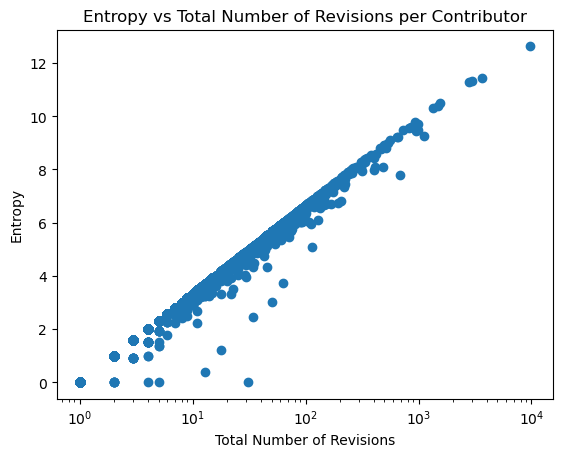

In [15]:

# Initialize Spark context
conf = SparkConf().setAppName("Wikipedia Revision Analysis")
sc = SparkContext.getOrCreate(conf=conf)

# 1. Extract Contributor IDs and Category Names
def extract_contributor_and_categories(line):
    """
    Extracts contributor IDs and category names from a line of XML.
    Returns a list of tuples (contributorID, categoryName).
    """
    contributor_ids = re.findall(r'<contributor>.*?<id>(\d+)</id>', line, re.DOTALL)
    categories = re.findall(r'\[\[Category:(.*?)\]\]', line)
    return [(contributor_id, category) for contributor_id in contributor_ids for category in categories]

# 2. Create a Key-Value Pair RDD
def create_kv_pair_rdd(rdd):
    """
    Transforms the input RDD into a key-value pair RDD with contributor IDs as keys
    and tuples containing a category name and revision count as values.
    """
    return rdd.flatMap(extract_contributor_and_categories) \
              .map(lambda x: ((x[0], x[1]), 1)) \
              .reduceByKey(lambda a, b: a + b) \
              .map(lambda x: (x[0][0], (x[0][1], x[1])))

# 3. Aggregate Data by Contributor
def aggregate_data(rdd):
    """
    Aggregates data by contributor to compute the total number of revisions,
    the number of distinct categories revised, and the entropy of the revision distribution.
    """
    def compute_entropy(counts):
        total = sum(counts)
        probabilities = [count/total for count in counts]
        return -sum(p * log2(p) for p in probabilities if p > 0)

    return rdd.groupByKey() \
              .mapValues(lambda vals: list(vals)) \
              .mapValues(lambda vals: (sum(x[1] for x in vals), len(set(x[0] for x in vals)), compute_entropy([x[1] for x in vals])))

# Process the data
kv_pair_rdd = create_kv_pair_rdd(rdd2)
aggregated_rdd = aggregate_data(kv_pair_rdd)

# 4. Output and Visualization
# Output 1: Display the top 10 contributors
top_contributors = aggregated_rdd.sortBy(lambda x: x[1][0], ascending=False).take(10)
print("Top 10 Contributors:", top_contributors)

# Output 2: Plot the entropy vs total number of revisions
contributions, entropy = zip(*[(x[1][0], x[1][2]) for x in aggregated_rdd.collect()])
plt.scatter(contributions, entropy)
plt.xscale('log')
plt.xlabel('Total Number of Revisions')
plt.ylabel('Entropy')
plt.title('Entropy vs Total Number of Revisions per Contributor')
plt.show()


## P2 Spark Dataframes

### P2.1 Creating a dataframe

Task: Create a Dataframe according to the following specification.

* Col 1 - name: page_id, type: LongType
* Col 2 - name: title, type: StringType
* Col 3 - name: contributor, type: List(contributor id: LongType, username: StringType)
* Col 4 - name: categories, type: ArrayType(elementType = StringType)
* Col 5 - name: revision_ts, type: TimestampType

Define the schema and then load the data (from the initial RDD (`rdd2`)) into this Dataframe.

Output 1: Show the schema

Output 2: Show the first 10 rows

Output 3: Show the count of the number of rows

Output 4: Show the number of Dataframe partitions.

Example (output 1): not given

Example (output 2): 

```
|     10| AccessibleComputing|    {20842734, Elli}|                  []|2021-01-23 15:15:01|
|     12|           Anarchism|{6068332, Wolfgan...|[Anarchism| , Ant...|2023-02-18 12:35:41|
...
```

Example (output 3): not given

Example (output 4): not given

In [16]:

schema = StructType([
    StructField("page_id", LongType(), True),
    StructField("title", StringType(), True),
    StructField("contributor", StructType([
        StructField("contributor_id", LongType(), True),
        StructField("username", StringType(), True)
    ]), True),
    StructField("categories", ArrayType(StringType(), True), True),
    StructField("revision_ts", TimestampType(), True)
])

In [17]:
def parse_xml_to_row(xml_string):
    # Using safe navigation with a conditional check
    page_id_match = re.search(r'<id>(\d+)</id>', xml_string)
    page_id = int(page_id_match.group(1)) if page_id_match else None
    
    title_match = re.search(r'<title>(.*?)</title>', xml_string)
    title = title_match.group(1) if title_match else None
    
    contributor_id_match = re.search(r'<contributor>.*?<id>(\d+)</id>', xml_string, re.DOTALL)
    contributor_id = int(contributor_id_match.group(1)) if contributor_id_match else None
    
    username_match = re.search(r'<username>(.*?)</username>', xml_string)
    username = username_match.group(1) if username_match else None
    
    categories = re.findall(r'\[\[Category:(.*?)\]\]', xml_string)
    
    revision_ts_match = re.search(r'<timestamp>(.*?)</timestamp>', xml_string)
    # Parsing the timestamp if found, else setting it to None
    revision_ts = datetime.strptime(revision_ts_match.group(1), "%Y-%m-%dT%H:%M:%SZ") if revision_ts_match else None
    
    # Only return a Row if essential fields are found
    if page_id and title and contributor_id and username:
        return Row(page_id=page_id, title=title, 
                   contributor=Row(contributor_id=contributor_id, username=username),
                   categories=categories, revision_ts=revision_ts)
    else:
        return None

# Filter out None rows before creating the DataFrame
rows = rdd2.map(parse_xml_to_row).filter(lambda x: x is not None)
df = spark.createDataFrame(rows, schema)


In [18]:
# Output 1: Show the schema
df.printSchema()

root
 |-- page_id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- contributor: struct (nullable = true)
 |    |-- contributor_id: long (nullable = true)
 |    |-- username: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- revision_ts: timestamp (nullable = true)



In [19]:
# Output 2: Show the first 10 rows
df.show(10, truncate=False)

+-------+------------------------------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|page_id|title                         |contributor          |categories                                                                                                                                                                                                                               |revision_ts        |
+-------+------------------------------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|10     |AccessibleComputing           |{20842734

In [20]:
# Output 3: Show the count of the number of rows
print(df.count())

24732


In [21]:
# Output 4: Show the number of DataFrame partitions
print(df.rdd.getNumPartitions())

8


### P2.2 Page title lengths

Task: Compute a Dataframe with the first column corresponding to page ID and the second column corresponding to page title length (in the number of words).

Output 1: Show the top 10 rows of sorted Dataframe in decreasing order of page title lengths.

Output 2: Show a plot with an x-axis corresponding to the page title length and a y-axis corresponding to the number of pages with the title length greater than the title length on the x-axis. Use a log scale for both the x and y-axis. Discuss the results.

Example (output 1): 

```
|  25165|          14|
|  28066|          14|
...
```

Example (output 2): not given



In [22]:

# Calculate the length of each title in terms of the number of words
title_length_df = df.withColumn("title_length", size(split(col("title"), " +")))

# Show the top 10 rows in decreasing order of title length
title_length_df.select("page_id", "title_length").orderBy(col("title_length").desc()).show(10)


+-------+------------+
|page_id|title_length|
+-------+------------+
|  25165|          14|
|  28066|          14|
|  30702|          13|
|   6202|          13|
|   6199|          13|
|  28042|          12|
|  18242|          11|
|   4139|          11|
|  31293|          11|
|  13458|          11|
+-------+------------+
only showing top 10 rows



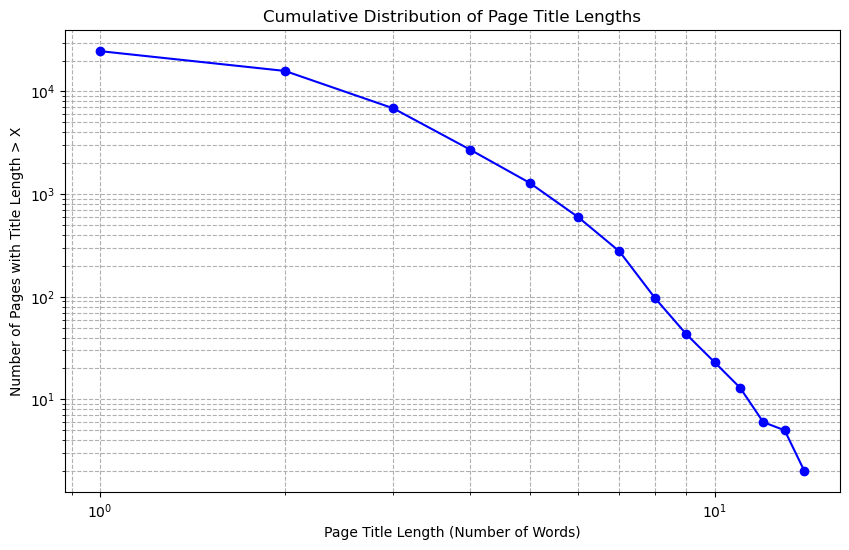

In [23]:

# Convert the title length DataFrame to Pandas for plotting
title_length_pd = title_length_df.select("title_length").toPandas()

# Count the occurrences of each title length
title_length_counts = title_length_pd['title_length'].value_counts().sort_index()

# Calculate the cumulative count of pages with title length greater than x
cumulative_counts = title_length_counts[::-1].cumsum()[::-1]

# Prepare the plot
plt.figure(figsize=(10, 6))
plt.loglog(cumulative_counts.index, cumulative_counts.values, marker='o', linestyle='-', color='blue')

# Labeling the axes and the plot
plt.xlabel('Page Title Length (Number of Words)')
plt.ylabel('Number of Pages with Title Length > X')
plt.title('Cumulative Distribution of Page Title Lengths')
plt.grid(True, which="both", ls="--")

# Display the plot
plt.show()


### Discussion of Results

- The plot shows that a small number of pages has very long titles, with the majority of pages having shorter titles. This is expected in a logarithmic distribution, where the frequency of longer titles drops off sharply.

- The log-log scale helps visualize the distribution's long tail, indicating that while most titles are concise, a fraction extends to much longer lengths.

- The cumulative count on the y-axis, indicating the number of pages with title lengths greater than a given length on the x-axis, emphasizes the skewed nature of title length distribution.

This approach and analysis provide insights into the structure and distribution of Wikipedia page titles, illustrating the variability in title length.

### P2.3 Content edits over time

Use the Dataframe API to:

Task: Compute the number of pages per revision timestamp sorted in decreasing order of the number of pages. 

Output 1: Show the top 20 rows.

Example:

```
|2002-02-25 15:51:15|   72|
|2002-02-25 15:43:11|   30|
...
```

Task: Compute the number of pages per year, sorted in increasing order of years. 

Output 2: Show the top 20 rows.

Example:

```
|2002|  246|
|2003|  167|
...
```


In [24]:

# Group by revision timestamp and count the number of pages
pages_per_revision = df.groupBy("revision_ts").agg(count("page_id").alias("num_pages"))

# Sort by the count in descending order
pages_per_revision_sorted = pages_per_revision.orderBy(col("num_pages").desc())

# Show the top 20 rows
pages_per_revision_sorted.show(20)


+-------------------+---------+
|        revision_ts|num_pages|
+-------------------+---------+
|2002-02-25 15:51:15|       50|
|2002-02-25 15:43:11|       19|
|2022-07-24 04:23:37|        8|
|2021-01-04 12:08:13|        7|
|2021-01-04 12:08:11|        6|
|2021-01-04 12:08:14|        5|
|2021-08-31 20:08:13|        5|
|2021-01-04 12:08:12|        5|
|2024-02-19 18:30:13|        5|
|2024-02-17 19:29:35|        4|
|2023-12-21 15:58:20|        3|
|2024-02-07 16:07:10|        3|
|2024-02-19 18:29:01|        3|
|2024-02-19 17:41:52|        3|
|2021-01-04 12:08:15|        3|
|2022-09-24 13:34:32|        3|
|2024-02-17 12:21:40|        2|
|2024-01-30 00:10:04|        2|
|2024-02-17 22:32:27|        2|
|2022-05-16 18:04:43|        2|
+-------------------+---------+
only showing top 20 rows



In [25]:

# Extract the year from revision_ts and group by it
pages_per_year = df.withColumn("year", year(col("revision_ts"))) \
                   .groupBy("year") \
                   .agg(count("page_id").alias("num_pages"))

# Sort by year in ascending order
pages_per_year_sorted = pages_per_year.orderBy(col("year"))

# Show the top 20 rows
pages_per_year_sorted.show(20)


+----+---------+
|year|num_pages|
+----+---------+
|2002|      199|
|2003|      149|
|2004|      166|
|2005|      179|
|2006|      221|
|2007|      113|
|2008|      123|
|2009|      160|
|2010|      190|
|2011|      124|
|2012|      429|
|2013|       96|
|2014|       85|
|2015|       77|
|2016|      109|
|2017|     1285|
|2018|      353|
|2019|      233|
|2020|      674|
|2021|      555|
+----+---------+
only showing top 20 rows



### P2.4 Number of categories versus text length

Task: Create a new Dataframe from the RDD defined in P1.1 that contains two columns, one for page ID and the other for the text length of Wikipedia pages (word count of the text enclosed with `<page>` and `</page>` XML tabs with carriage-return characters removed.

Use this Dataframe and the Dataframe defined in P2.1 to create a new Dataframe with two columns: the first column corresponding to the number of page categories and the second column corresponding to the page text length.

Output 1: Show the top 20 rows of this table sorted in decreasing order of page text lengths. 

Output 2: Show a plot of the number of categories versus the page text length.

Example (output 1): 
```
|  39582|             1|      48352|
|  13224|             2|      48274|
...
```

Example (output 2): not given


In [26]:

def extract_page_id_and_text_length(xml_string):
    page_id_match = re.search(r'<id>(\d+)</id>', xml_string)
    page_id = int(page_id_match.group(1)) if page_id_match else None
    
    # Removing carriage-return characters and calculating word count
    text_length = len(re.sub(r'\n', ' ', xml_string).split()) if xml_string else 0
    
    return (page_id, text_length)

# Apply the function to rdd2 and create a DataFrame
page_text_length_rdd = rdd2.map(extract_page_id_and_text_length)
page_text_length_df = spark.createDataFrame(page_text_length_rdd, ["page_id", "text_length"])


In [27]:
# Assuming df from P2.1 is available and includes a 'categories' column
df_with_categories_count = df.withColumn("num_categories", size(col("categories")))

# Join on page_id
df_joined = df_with_categories_count.join(page_text_length_df, "page_id")

# Select only the number of categories and text length
final_df = df_joined.select("num_categories", "text_length")

# Sort by text_length in descending order
final_df_sorted = final_df.orderBy(col("text_length").desc())

# Show the top 20 rows
final_df_sorted.show(20)


+--------------+-----------+
|num_categories|text_length|
+--------------+-----------+
|            61|      49974|
|             1|      49742|
|             2|      44304|
|            22|      44093|
|            42|      43668|
|             2|      42894|
|             5|      42804|
|             5|      42600|
|             7|      40528|
|            19|      39429|
|             2|      38948|
|            19|      38586|
|            15|      38322|
|            13|      37254|
|             1|      37221|
|             8|      36673|
|            34|      36458|
|            21|      36380|
|            41|      36128|
|             1|      35968|
+--------------+-----------+
only showing top 20 rows



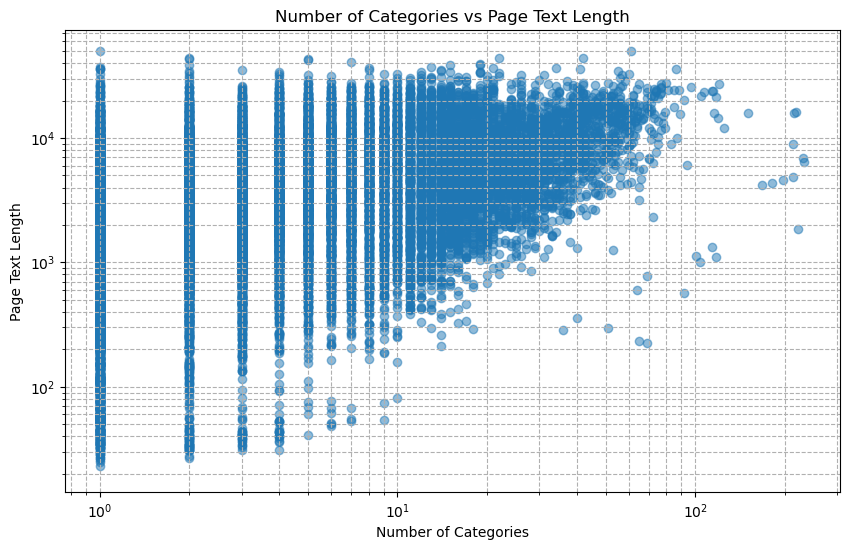

In [28]:

# Collect data for plotting
data_for_plot = final_df_sorted.collect()
num_categories = [row['num_categories'] for row in data_for_plot]
text_lengths = [row['text_length'] for row in data_for_plot]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(num_categories,text_lengths , alpha=0.5)
plt.title('Number of Categories vs Page Text Length')
plt.ylabel('Page Text Length')
plt.xlabel('Number of Categories')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



## P3 Spark SQL and Dataframes

### P3.1 A Spark SQL range query

Task: Create a temporary view for the Dataframe created in P2.1.

Output 1: Write a Spark SQL query to select rows which correspond to pages that were revised in January of 2023, ordered by revision time in decreasing order. Show top 20 rows.

Output 2: Write a Spark SQL query to count the number of pages that were revised in January 2023. Show the count.

Example (output 1): 
```
|  16488|       Julian Jaynes| {6831532, Martindo}|[1920 births, 199...|2023-01-31 23:47:12|
|  37162|     Roland Freisler|{45155473, Abdul ...|[1893 births, 194...|2023-01-31 23:35:28|
...
```

Example (output 2): not given





In [29]:
# create df from P2.1 again
rows = rdd2.map(parse_xml_to_row).filter(lambda x: x is not None)
df = spark.createDataFrame(rows, schema)

In [30]:
df.createOrReplaceTempView("pages")

In [31]:
query_1 = """
SELECT *
FROM pages
WHERE revision_ts >= '2023-01-01' AND revision_ts < '2023-02-01'
ORDER BY revision_ts DESC
"""

january_revisions = spark.sql(query_1)
january_revisions.show(20, False)


+-------+-----------------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|page_id|title                              |contributor              |categories                                                                                                                                                                                                                              |revision_ts        |
+-------+-----------------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|25296  |Quid            

In [32]:
query_2 = """
SELECT COUNT(*) as count
FROM pages
WHERE revision_ts >= '2023-01-01' AND revision_ts < '2023-02-01'
"""

january_revision_count = spark.sql(query_2)
january_revision_count.show()


+-----+
|count|
+-----+
|   95|
+-----+



### P3.2 Categories again

Task 1: Use the Dataframe defined in P2.1 as input (call this `df1`). Use the DataFrame API to define a Dataframe with two columns: the first column containing distinct categories in `df1`, and the second column corresponding to the number of pages per distinct category, with rows sorted in decreasing order of the second column values. 

Output 1: Show the top 20 rows.

Example:

```
|Articles containi...|  613|
|       Living people|  596|
...
```


Task 2: Using `df1`, define a new Dataframe `df2` with two columns: the first column containing page ID and the second containing the category of the page. There should be a row in this Dataframe with column values `(pid, cat)` for each occurrence of category `cat` in page `pid`. Create a temporary view for a table with the name `wiki_cat` using `df2`.

Output 2: Write a Spark SQL query to count the number of pages per category and show the results in decreasing order of this count.

Example (partial):

```
+-------+--------------------+
|page_id|            category|
+-------+--------------------+
|     12|         Anarchism| |
|     12|     Anti-capitalism|
...
|     25|    1910s neologisms|
|     39|Land surface effe...|
|     39|Climate change fe...|
...
```

In [33]:

# create df from P2.1 again
rows = rdd2.map(parse_xml_to_row).filter(lambda x: x is not None)
df1 = spark.createDataFrame(rows, schema)

# Explode the 'categories' array to create a row for each category per page
df_exploded = df1.select(explode(col("categories")).alias("category"))

# Group by the category and count the number of pages per category
df_category_count = df_exploded.groupBy("category").agg(count("*").alias("num_pages"))

# Sort the result in decreasing order of the number of pages
df_sorted_category_count = df_category_count.orderBy(col("num_pages").desc())


In [34]:
df_sorted_category_count.show(20, False)


+----------------------------------------------------+---------+
|category                                            |num_pages|
+----------------------------------------------------+---------+
|Articles containing video clips                     |554      |
|Living people                                       |506      |
|Days of the year                                    |432      |
|20th-century American male writers                  |176      |
|Popes                                               |155      |
|Year of birth unknown                               |144      |
|Member states of the United Nations                 |118      |
|20th-century American novelists                     |113      |
|Members of the American Philosophical Society       |107      |
|American male non-fiction writers                   |106      |
|American male novelists                             |105      |
|Italian popes                                       |104      |
|American people of Engli

### Task 2:

In [35]:

# create df from P2.1 again
rows = rdd2.map(parse_xml_to_row).filter(lambda x: x is not None)
df1 = spark.createDataFrame(rows, schema)
df2 = df1.select(col("page_id"), explode(col("categories")).alias("category"))


In [36]:
df2.createOrReplaceTempView("wiki_cat")


In [37]:
query = """
SELECT category, COUNT(page_id) AS num_pages
FROM wiki_cat
GROUP BY category
ORDER BY num_pages DESC
"""

result = spark.sql(query)
result.show()

+--------------------+---------+
|            category|num_pages|
+--------------------+---------+
|Articles containi...|      554|
|       Living people|      506|
|    Days of the year|      432|
|20th-century Amer...|      176|
|               Popes|      155|
|Year of birth unk...|      144|
|Member states of ...|      118|
|20th-century Amer...|      113|
|Members of the Am...|      107|
|American male non...|      106|
|American male nov...|      105|
|       Italian popes|      104|
|American people o...|      103|
|Leap years in the...|       95|
|Fellows of the Ro...|       93|
|   Chemical elements|       93|
|Fellows of the Am...|       92|
|American male fil...|       91|
| American inventions|       91|
|Grammy Award winners|       90|
+--------------------+---------+
only showing top 20 rows



### P3.3 Saving a table

Task: Use the Dataframe defined in P2.1 as input. Create a new Dataframe with two additional columns: one containing the year of revision time and the other containing the month of revision time. Call these new columns as `ts_year` and `ts_month`. Save this Dataframe to a table with the name `wikipersisted` using `ts_year` and `ts_month` as partitioning columns and using overwrite mode.

Output 1: Now read the table `wikipersisted` using `spark.read.table` to a Dataframe. Show the top 20 rows of this Dataframe.

Example:

```
|  16209|         Justinian I|{38912470, Chario...|[Justinian I| , 4...|2023-02-17 20:54:12|   2023|       2|
|  16211|         John Martyn|        {null, null}|[1948 births, 200...|2023-02-05 00:26:37|   2023|       2|
...
```

Output 2: Run `spark.sql("DESCRIBE EXTENDED wikipersisted;").show(30)`. Explain the content of the output.

Example (partial):

```
+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|             page_id|              bigint|   null|
|               title|              string|   null|
...
```

In [38]:

# create df from P2.1 again
rows = rdd2.map(parse_xml_to_row).filter(lambda x: x is not None)
df = spark.createDataFrame(rows, schema)

df_with_year_month = df.withColumn("ts_year", year("revision_ts"))\
                       .withColumn("ts_month", month("revision_ts"))


In [39]:
path = "gs://dataproc-temp-europe-west6-1058904218856-nazqwes0/spark_output/wikipersisted"

df_with_year_month.write.mode("overwrite")\
    .partitionBy("ts_year", "ts_month")\
    .option("path", path)\
    .saveAsTable("wikipersisted")


ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
24/02/22 15:36:13 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [40]:
# Read the table 'wikipersisted'
df_wikipersisted = spark.read.table("wikipersisted")

# Show the top 20 rows
df_wikipersisted.show(20, False)


+-------+---------------------------+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
# Describe the extended properties of 'wikipersisted'
spark.sql("DESCRIBE EXTENDED wikipersisted;").show(30, False)


+----------------------------+---------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                        |comment|
+----------------------------+---------------------------------------------------------------------------------+-------+
|page_id                     |bigint                                                                           |null   |
|title                       |string                                                                           |null   |
|contributor                 |struct<contributor_id:bigint,username:string>                                    |null   |
|categories                  |array<string>                                                                    |null   |
|revision_ts                 |timestamp                                                                        |null   |
|ts_year                     |in


### Explanation of the Outputs

- **Year and Month Columns**: The `year` and `month` functions are used to extract the year and month from the `revision_ts` timestamp column, creating new columns `ts_year` and `ts_month`. This enables partitioning by these time components.

- **Saving DataFrame**: The `.write.mode("overwrite")` operation saves the DataFrame as a table named `wikipersisted`, partitioned by `ts_year` and `ts_month`. Partitioning by these columns can significantly improve query performance on large datasets by limiting the amount of data read for queries filtered by year and month.

- **Reading and Displaying**: Reading the table back into a DataFrame and displaying the top rows verifies that the save operation succeeded and that the data is structured as expected.

- **Describe Extended**: The `DESCRIBE EXTENDED` SQL command provides detailed information about the table, including its schema (`col_name`, `data_type`), location on the filesystem, and partitioning columns. This metadata is crucial for understanding how Spark manages and accesses the table data.

This solution leverages Spark SQL's capabilities for managing structured data, enhancing it with temporal components for partitioning, and efficiently storing and accessing large datasets.

### Appendix 1: Acknowledgement: The use of generative AI tools

I acknowledge the use of GPT-4 (OpenAI, https://openai.com/gpt-4) to provide initial outlines to questions, to provide appropriate functions and syntax to some of the problems, and to debug errors in the code. The chat-log is linked in a separate file stored in the GitHub repository.